# Key notebook with examples of code for maintaining the cureated set of histones
- spcific manupulations can be done in copies of this notebook.

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from curated_set_services import CuratedSet, GFFwrite
from curated_set_services import show_msa_jl, dict2tree, muscle_p2p_aln
# from pynucl.hist_features import hist_shf4seq, hist_features
from Bio.Align.AlignInfo import SummaryInfo
from Bio import AlignIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
# from pytexshade import ipyshade
from ete3 import Tree, TreeStyle
import json
import pandas as pd
!mkdir -p tmp

In [4]:
#Load data from histones.csv
curated_set = CuratedSet()
cs=curated_set

In [5]:
#Access pandas dataframe with the histones information
#cs.data
cs.data.head()

accession type variant_group         variant doublet  \
NP_505463.1        NP_505463.1  H2A          cH2A  cH2A_(Animals)           
EEC09557.1          EEC09557.1  H2A          cH2A  cH2A_(Animals)           
NP_724343.1        NP_724343.1  H2A          cH2A  cH2A_(Animals)           
XP_001119899.1  XP_001119899.1  H2A          cH2A  cH2A_(Animals)           
EDO48405.1          EDO48405.1  H2A          cH2A  cH2A_(Animals)           

                       gi ncbi_gene_id hgnc_gene_name taxonomy_id  \
NP_505463.1      17562014                                    6239   
EEC09557.1      215500063                                    6945   
NP_724343.1      24585673                                    7227   
XP_001119899.1  110764935                                    7460   
EDO48405.1      156227602                                   45351   

                               organism      phylum        class  \
NP_505463.1      Caenorhabditis elegans    Nematoda  Chromadorea   
EEC09557.1            Ixodes scapularis  Arthropoda    Arachnida   
NP_724343.1     Drosophila melanogaster  Arthropoda      Insecta   
XP_001119899.1           Apis mellifera  Arthropoda      Insecta   
EDO48405.1       Nematostella vectensis    Cnidaria     Anthozoa   

               taxonomy_group info            references  \
NP_505463.1                         26989147 22650316(?)   
EEC09557.1                          26989147 22650316(?)   
NP_724343.1                         26989147 22650316(?)   
XP_001119899.1                      26989147 22650316(?)   
EDO48405.1                          26989147 22650316(?)   

                                                         sequence  
NP_505463.1     MSGRGKGGKAKTGGKAKSRSSRAGLQFPVGRLHRILRKGNYAQRVG...  
EEC09557.1      MSGRGKGGKVKGKSKTRSSRAGLQFPVGRIHRLLRKGNYAERVGAG...  
NP_724343.1     MSGRGKGGKVKGKAKSRSNRAGLQFPVGRIHRLLRKGNYAERVGAG...  
XP_001119899.1  MSGRGKGGKAKAKAKSRSNRAGLQFPVGRIHRLLRKGNYAERVGAG...  
EDO48405.1      MSGRGKGKAKGTKSKTRSSRAGLQFPVGRIHRHLRKGNYAERVGAG...

In [6]:
cs.data.shape

(449, 16)

## Subsetting and accessing data about histones

In [7]:
#cs.data.accession
#cs.data['accession']
# cs.data[cs.data.type == 'H2A']
# cs.data[(cs.data['type'] == 'H2A') & (cs.data['class'] == 'Mammalia')]
cs.data.query('type == "H2A" & `class`=="Mammalia" & variant.str.contains("H2A.Z")', engine='python')['accession']

NP_002097.1    NP_002097.1
NP_036544.1    NP_036544.1
NP_958844.1    NP_958844.1
NP_619541.1    NP_619541.1
NP_958924.1    NP_958924.1
NP_958925.1    NP_958925.1
Name: accession, dtype: object

## Importing  human_histones.csv into histones.csv

In [8]:
df = pd.read_csv("human_histones.csv",engine='python').fillna('')
df.shape, df.columns

((130, 20),
 Index(['accession', 'type', 'variant_group', 'variant', 'Histone variant',
        'Clustered (canonical) isoform', 'ncbi_gene_id', 'hgnc_gene_name',
        'Ensembl gene ID', 'Transcript stable ID', 'RefSeq mRNA ID',
        'RefSeq peptide ID', 'Protein length', 'taxonomy_id', 'organism',
        'phylum', 'class', 'taxonomy_group', 'info', 'references'],
       dtype='object'))

In [9]:
print("Dropping %d records"%len(df[df["accession"] == ""]))
df = df.drop(df[df["accession"] == ""].index)
df.shape

Dropping 23 records


(107, 20)

In [10]:
df_to_add = df[['accession', 'type', 'variant_group', 'variant', 'ncbi_gene_id', 'hgnc_gene_name',
                'taxonomy_id', 'organism', 'phylum', 'class', 'taxonomy_group', 'info', 'references']]
df_to_add['sequence'] = ['']*df_to_add.shape[0]
df_to_add.head()

accession type variant_group              variant  ncbi_gene_id  \
0  NP_005309   H1          H1.0  H1.0_(Homo_sapiens)          3005   
1  NP_005316   H1          H1.1  H1.1_(Homo_sapiens)          3024   
2  NP_005310   H1          H1.2  H1.2_(Homo_sapiens)          3006   
3  NP_005311   H1          H1.3  H1.3_(Homo_sapiens)          3007   
4  NP_005312   H1          H1.4  H1.4_(Homo_sapiens)          3008   

  hgnc_gene_name  taxonomy_id      organism    phylum     class  \
0           H1-0         9606  Homo sapiens  Chordata  Mammalia   
1           H1-1         9606  Homo sapiens  Chordata  Mammalia   
2           H1-2         9606  Homo sapiens  Chordata  Mammalia   
3           H1-3         9606  Homo sapiens  Chordata  Mammalia   
4           H1-4         9606  Homo sapiens  Chordata  Mammalia   

  taxonomy_group info references sequence  
0       Mammalia        26689747           
1       Mammalia        26689747           
2       Mammalia        26689747           
3       Mammalia        26689747           
4       Mammalia        26689747

In [11]:
# Remove human histones from the dataset
print("Dropping %d records"%len(cs.data[cs.data.taxonomy_id == "9606"]))
cs.data = cs.data.drop(cs.data[cs.data.taxonomy_id == "9606"].index)
cs.data.shape

Dropping 107 records


(342, 16)

In [12]:
cs.data.head(3)

accession type variant_group         variant doublet  \
NP_505463.1  NP_505463.1  H2A          cH2A  cH2A_(Animals)           
EEC09557.1    EEC09557.1  H2A          cH2A  cH2A_(Animals)           
NP_724343.1  NP_724343.1  H2A          cH2A  cH2A_(Animals)           

                    gi ncbi_gene_id hgnc_gene_name taxonomy_id  \
NP_505463.1   17562014                                    6239   
EEC09557.1   215500063                                    6945   
NP_724343.1   24585673                                    7227   

                            organism      phylum        class taxonomy_group  \
NP_505463.1   Caenorhabditis elegans    Nematoda  Chromadorea                  
EEC09557.1         Ixodes scapularis  Arthropoda    Arachnida                  
NP_724343.1  Drosophila melanogaster  Arthropoda      Insecta                  

            info            references  \
NP_505463.1       26989147 22650316(?)   
EEC09557.1        26989147 22650316(?)   
NP_724343.1       26989147 22650316(?)   

                                                      sequence  
NP_505463.1  MSGRGKGGKAKTGGKAKSRSSRAGLQFPVGRLHRILRKGNYAQRVG...  
EEC09557.1   MSGRGKGGKVKGKSKTRSSRAGLQFPVGRIHRLLRKGNYAERVGAG...  
NP_724343.1  MSGRGKGGKVKGKAKSRSNRAGLQFPVGRIHRLLRKGNYAERVGAG...

In [13]:
cs.data=cs.data.append(df_to_add)
cs.data.shape

(449, 16)

In [14]:
cs.data = cs.data.fillna('')
cs.data.tail(3)

accession type variant_group             variant doublet gi  \
127     NP_003539   H4           cH4  cH4_(Homo_sapiens)              
128  NP_001029249   H4           cH4  cH4_(Homo_sapiens)              
129     NP_778224   H4           cH4  cH4_(Homo_sapiens)              

    ncbi_gene_id hgnc_gene_name taxonomy_id      organism    phylum     class  \
127         8370          H4C14        9606  Homo sapiens  Chordata  Mammalia   
128       554313          H4C15        9606  Homo sapiens  Chordata  Mammalia   
129       121504          H4C16        9606  Homo sapiens  Chordata  Mammalia   

    taxonomy_group info references sequence  
127       Mammalia        12408966           
128       Mammalia        12408966           
129       Mammalia        12408966

## Technical maintenance of the list

In [15]:
# Identifying duplicated accessions
list(cs.has_duplicates())

[]

In [16]:
# check with NCBI if accesssions have new versions and update them. E.g. NP_12345.1 has now NP_12345.2.
from Bio import Entrez
Entrez.email = 'histoneDB@intbio.org'
cs.update_accession_version()
cs.data=cs.data.set_index(cs.data.accession.values)

NP_005309 changes to NP_005309.1
NP_005316 changes to NP_005316.1
NP_005310 changes to NP_005310.1
NP_005311 changes to NP_005311.1
NP_005312 changes to NP_005312.1
NP_005313 changes to NP_005313.1
NP_005314 changes to NP_005314.2
NP_861453 changes to NP_861453.1
NP_722575 changes to NP_722575.1
NP_001295191 changes to NP_001295191.1
NP_006017 changes to NP_006017.1
NP_734466 changes to NP_734466.1
NP_003504 changes to NP_003504.2
NP_003503 changes to NP_003503.1
NP_066409 changes to NP_066409.1
NP_066390 changes to NP_066390.1
NP_066408 changes to NP_066408.1
NP_542163 changes to NP_542163.1
NP_003500 changes to NP_003500.1
NP_066544 changes to NP_066544.1
NP_003501 changes to NP_003501.1
NP_003502 changes to NP_003502.1
NP_003505 changes to NP_003505.1
NP_003507 changes to NP_003507.1
NP_001035807 changes to NP_001035807.1
NP_003508 changes to NP_003508.1
NP_778235 changes to NP_778235.1
NP_254280 changes to NP_254280.1
NP_002097 changes to NP_002097.1
NP_036544 changes to NP_036544.

In [17]:
#Fetch and update taxids and taxonomic data from NCBI by accessions
curated_set.update_taxids() #update only for blank data use blank_data=True, update for specific accessions use accessions=[<list of accessions>]

Fetched taxid from NCBI 6239
Fetched taxid from NCBI 6945
Fetched taxid from NCBI 7227
Fetched taxid from NCBI 7460
Fetched taxid from NCBI 45351
Fetched taxid from NCBI 7955
Fetched taxid from NCBI 8355
Fetched taxid from NCBI 9031
Fetched taxid from NCBI 9483
Fetched taxid from NCBI 9544
Fetched taxid from NCBI 9598
Fetched taxid from NCBI 9615
Fetched taxid from NCBI 9646
Fetched taxid from NCBI 9785
Fetched taxid from NCBI 9823
Fetched taxid from NCBI 9913
Fetched taxid from NCBI 9986
Fetched taxid from NCBI 10029
Fetched taxid from NCBI 10090
Fetched taxid from NCBI 10116
Fetched taxid from NCBI 10141
Fetched taxid from NCBI 10181
Fetched taxid from NCBI 13616
Fetched taxid from NCBI 61853
Fetched taxid from NCBI 10090
Fetched taxid from NCBI 3555
Fetched taxid from NCBI 3702
Fetched taxid from NCBI 3702
Fetched taxid from NCBI 3702
Fetched taxid from NCBI 3702
Fetched taxid from NCBI 4577
Fetched taxid from NCBI 4577
Fetched taxid from NCBI 39947
Fetched taxid from NCBI 5911
Fetc

In [18]:
#Update sequences
curated_set.update_sequence() #update only for blank data use blank_data=True

Fetching 420 seqs
Sequence for NP_005309.1 changes from  to MTENSTSAPAAKPKRAKASKKSTDHPKYSDMIVAAIQAEKNRAGSSRQSIQKYIKSHYKVGENADSQIKLSIKRLVTTGVLKQTKGVGASGSFRLAKSDEPKKSVAFKKTKKEIKKVATPKKASKPKKAASKAPTKKPKATPVKKAKKKLAATPKKAKKPKTVKAKPVKASKPKKAKPVKPKAKSSAKRAGKKK
Sequence for NP_005316.1 changes from  to MSETVPPAPAASAAPEKPLAGKKAKKPAKAAAASKKKPAGPSVSELIVQAASSSKERGGVSLAALKKALAAAGYDVEKNNSRIKLGIKSLVSKGTLVQTKGTGASGSFKLNKKASSVETKPGASKVATKTKATGASKKLKKATGASKKSVKTPKKAKKPAATRKSSKNPKKPKTVKPKKVAKSPAKAKAVKPKAAKARVTKPKTAKPKKAAPKKK
Sequence for NP_005310.1 changes from  to MSETAPAAPAAAPPAEKAPVKKKAAKKAGGTPRKASGPPVSELITKAVAASKERSGVSLAALKKALAAAGYDVEKNNSRIKLGLKSLVSKGTLVQTKGTGASGSFKLNKKAASGEAKPKVKKAGGTKPKKPVGAAKKPKKAAGGATPKKSAKKTPKKAKKPAAATVTKKVAKSPKKAKVAKPKKAAKSAAKAVKPKAAKPKVVKPKKAAPKKK
Sequence for NP_005311.1 changes from  to MSETAPLAPTIPAPAEKTPVKKKAKKAGATAGKRKASGPPVSELITKAVAASKERSGVSLAALKKALAAAGYDVEKNNSRIKLGLKSLVSKGTLVQTKGTGASGSFKLNKKAASGEGKPKAKKAGAAKPRKPAGAAKKPKKVAGAATPKKSIKKTPKKVKKPATAAGTKKVAKSAKKVKTPQPKKAAKS

In [19]:
cs.data.at['HISTDB_H2A_L_0', 'sequence'] = 'MAGNKHSRSSCKPRRQCLSRSRRAELQFPVSHMERCLREGQYARHLSSTTPVFLAAVLEYLTANILEQAGKEAQNSHRVCITPEHLKRALQKNEQLRWILEEEDDIHSQEEEMPQPEEEEEEDERMEEEEEEKKEEEEKEEEEDERMEEEEEEKKEEEEKKEEKEKEEEKEKKKKKGGFLSFRAVQDFISNLFQLLKFP'
cs.data.at['HISTDB_H2A_L_1', 'sequence'] = 'MAGNKMFCRPRRQRLSHSRRAELQFPVSHLERCLRESQHARHLSSTTPVFLAGVLEYLTANILEKVGKEVKNSCRLCITPEHVKRALQKDEQLRWILELEDDTHSQVEEMPQSEEEEEEEEEKEEEMVVLVVMGGRRRRRRRRRRKDS'

In [20]:
cs.data.tail()

accession type variant_group               variant  \
HISTDB_H3_Y_1    HISTDB_H3_Y_1   H3          H3.Y             H3.Y__???   
HISTDB_H3_Y_2    HISTDB_H3_Y_2   H3          H3.Y             H3.Y__???   
HISTDB_H3_Y_3    HISTDB_H3_Y_3   H3          H3.Y             H3.Y__???   
HISTDB_H2A_L_0  HISTDB_H2A_L_0  H2A     short_H2A  H2A.L_(Homo_sapiens)   
HISTDB_H2A_L_1  HISTDB_H2A_L_1  H2A     short_H2A  H2A.L_(Homo_sapiens)   

               doublet    gi ncbi_gene_id hgnc_gene_name taxonomy_id  \
HISTDB_H3_Y_1           NOGI                                    9544   
HISTDB_H3_Y_2           NOGI                                    9598   
HISTDB_H3_Y_3           NOGI                                    9598   
HISTDB_H2A_L_0                  115482714         H2AL1Q        9606   
HISTDB_H2A_L_1                  115482686          H2AL3        9606   

                       organism    phylum     class taxonomy_group info  \
HISTDB_H3_Y_1    Macaca mulatta  Chordata  Mammalia                       
HISTDB_H3_Y_2   Pan troglodytes  Chordata  Mammalia                       
HISTDB_H3_Y_3   Pan troglodytes  Chordata  Mammalia                       
HISTDB_H2A_L_0     Homo sapiens  Chordata  Mammalia       Mammalia        
HISTDB_H2A_L_1     Homo sapiens  Chordata  Mammalia       Mammalia        

                       references  \
HISTDB_H3_Y_1                       
HISTDB_H3_Y_2                       
HISTDB_H3_Y_3                       
HISTDB_H2A_L_0  29549088 35099534   
HISTDB_H2A_L_1  29549088 35099534   

                                                         sequence  
HISTDB_H3_Y_1   ARTKQTARKATNWQAPRKPLATKAPGKRLPPRGGIKKPHRYRPGTQ...  
HISTDB_H3_Y_2   ARTKQTARKATAWQAPRKPLATKAAGKRAPPTGGIKKPHRYKPGTL...  
HISTDB_H3_Y_3   ARTKQTARKATAWQAPRKPLATKAARKRASPTGGIKKPHRYKPGTL...  
HISTDB_H2A_L_0  MAGNKHSRSSCKPRRQCLSRSRRAELQFPVSHMERCLREGQYARHL...  
HISTDB_H2A_L_1  MAGNKMFCRPRRQRLSHSRRAELQFPVSHLERCLRESQHARHLSST...

In [21]:
cs.save() #cs.save(filename='<filename>')

variant_group  self      NaN
               other     NaN
taxonomy_id    self     9606
               other    9606
Name: HISTDB_H2A_L_1, dtype: object
variant_group  self     cH3.1
               other      cH3
taxonomy_id    self       NaN
               other      NaN
Name: NP_066298.1, dtype: object
variant_group  self      NaN
               other     NaN
taxonomy_id    self     9606
               other    9606
Name: HISTDB_H2A_L_0, dtype: object
variant_group  self     cH3.2
               other      cH3
taxonomy_id    self       NaN
               other      NaN
Name: NP_001116847.1, dtype: object
variant_group  self     H3.Y.2
               other      H3.Y
taxonomy_id    self        NaN
               other       NaN
Name: NP_001358848.1, dtype: object
variant_group  self     cH3.1
               other      cH3
taxonomy_id    self       NaN
               other      NaN
Name: NP_003528.1, dtype: object
variant_group  self     cH3.2
               other      cH3
taxonomy_id   

## Multiple Sequence Alignment, trimming, visualization

In [100]:
#Make algnment with Muscle
msa=cs.muscle_aln(cs.data.query('type == "H2A" & variant.str.contains("H2A.Z") & `class`=="Mammalia"', engine='python')['accession'],options=["-maxiters","16","-gapopen","-20"],debug=False)

In [101]:
#View MSA inline in jupyterlab with jupyterlab-fasta extension, otherwise will just print it.
show_msa_jl(msa)

>H2A.Z.1_Homo_sapiens_H2AZ1_NP_002097.1 NP_002097.1 histone: H2A variant: H2A.Z.1_(Homo_sapiens) organism: Homo sapiens
MAGGKAGKDSGKAKTKAVSRSQRAGLQFPVGRIHRHLKSRTTSHGRVGATAAVYSAAILE
YLTAEVLELAGNASKDLKVKRITPRHLQLAIRGDEELDSLIKATIAGGGVIPHIHKSLIG
KKGQQKTV
>H2A.Z.2.s3_Homo_sapiens_H2AZ2_NP_958844.1 NP_958844.1 histone: H2A variant: H2A.Z.2.s3_(Homo_sapiens) organism: Homo sapiens
--------------------------MFPVGRIHRHLKTRTTSHGRVGATAAVYSAAILE
YLTAEVLELAGNASKDLKVKRITPRHLQLAIRGDEELDSLIKATIAGGGVIPHIHKSLIG
KKGQQKTA
>H2A.Z.2.s2_Homo_sapiens_H2AZ2_NP_619541.1 NP_619541.1 histone: H2A variant: H2A.Z.2.s2_(Homo_sapiens) organism: Homo sapiens
MAGGKAGKDSGKAKAKAVSRSQRAGLQFPVGRIHRHLKTRTTSHGRVGATAAVYSAAILE
YLTAEVLELAGNASKDLKVKRITPRHLQLAIRGDEELDSLIKATIAGGEKRRCS------
--------
>H2A.Z.2.s5_Homo_sapiens_H2AZ2_NP_958925.1 NP_958925.1 histone: H2A variant: H2A.Z.2.s5_(Homo_sapiens) organism: Homo sapiens
MAGGKAGKDSGKAKAKAVSRSQRAGLQ---------------------------------
-----VLELAGNASKDLKVKRITPRHLQLAIRGDEELDSLIKATIAGG

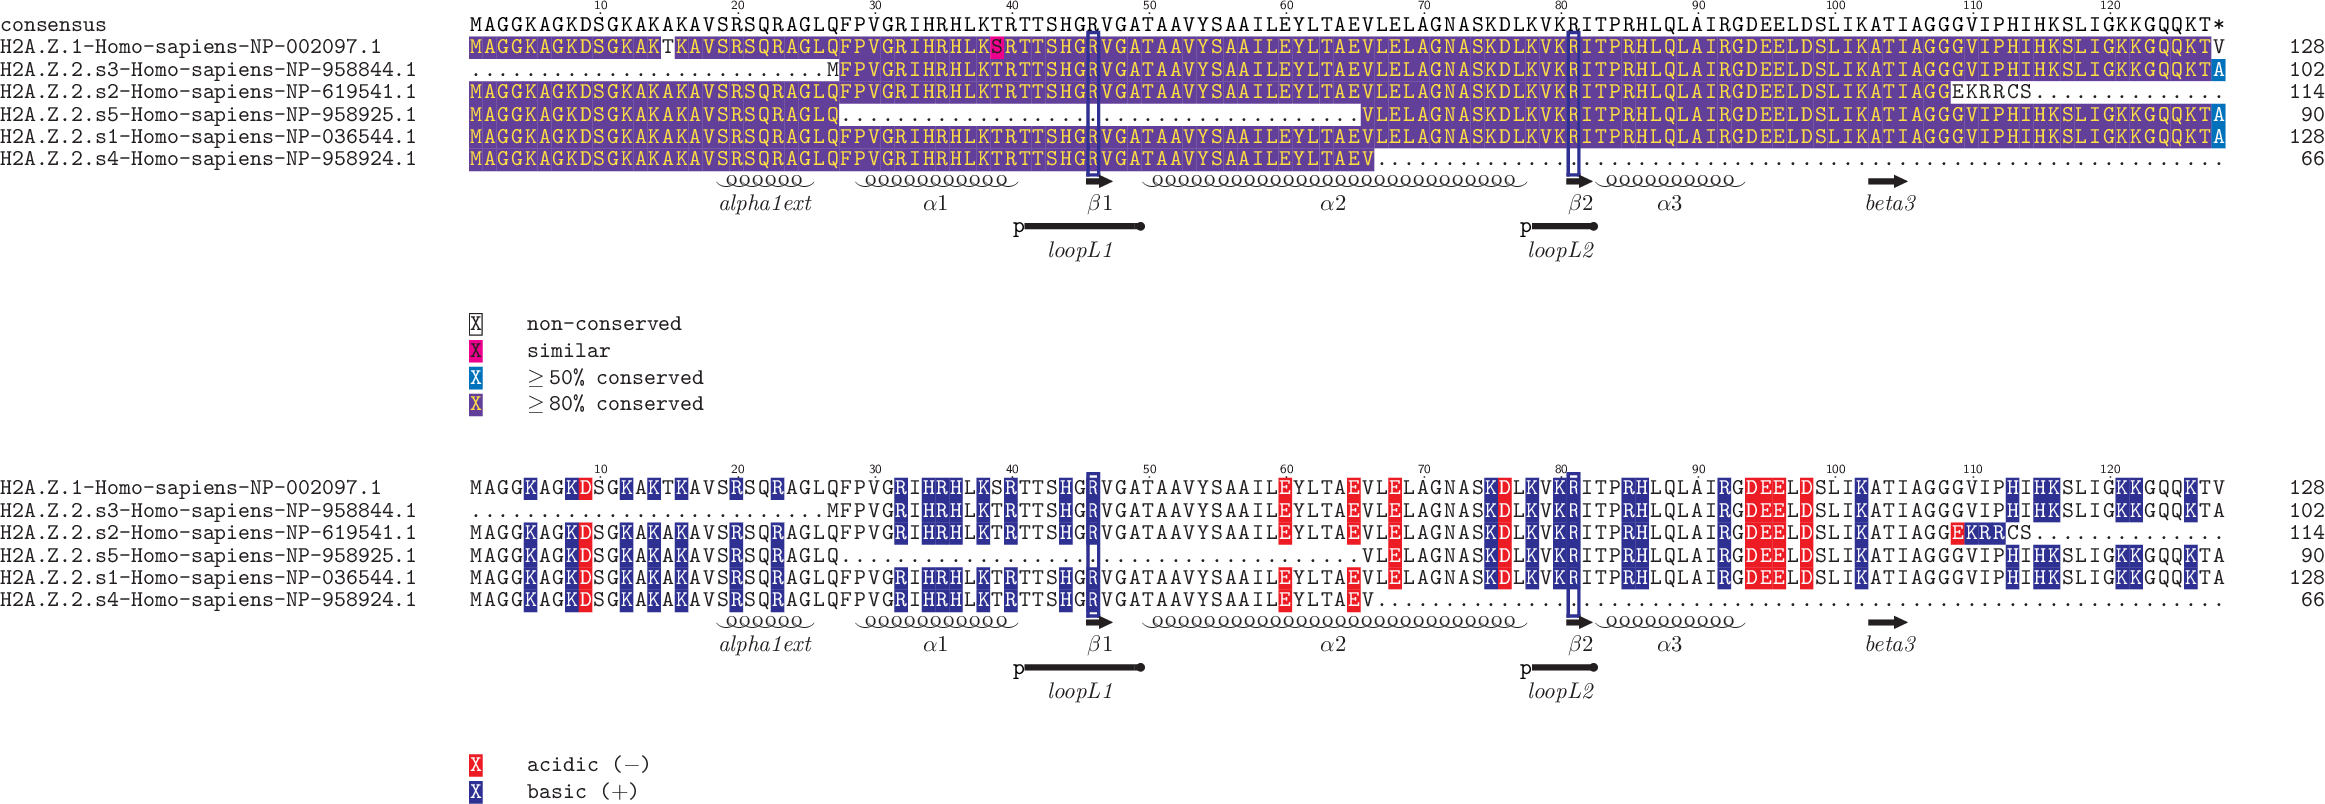

In [205]:
#via pytexshade, see function options here https://github.com/intbio/pytexshade/blob/3b4620c95f6607fffc06063f582bdb294d68fc09/pytexshade/shade.py#L134
ipyshade.shadedmsa(msa,shading_modes=['similar','charge_functional'],ruler=True,features=hist_shf4seq(SummaryInfo(msa).dumb_consensus(threshold=0.1,ambiguous='X')))

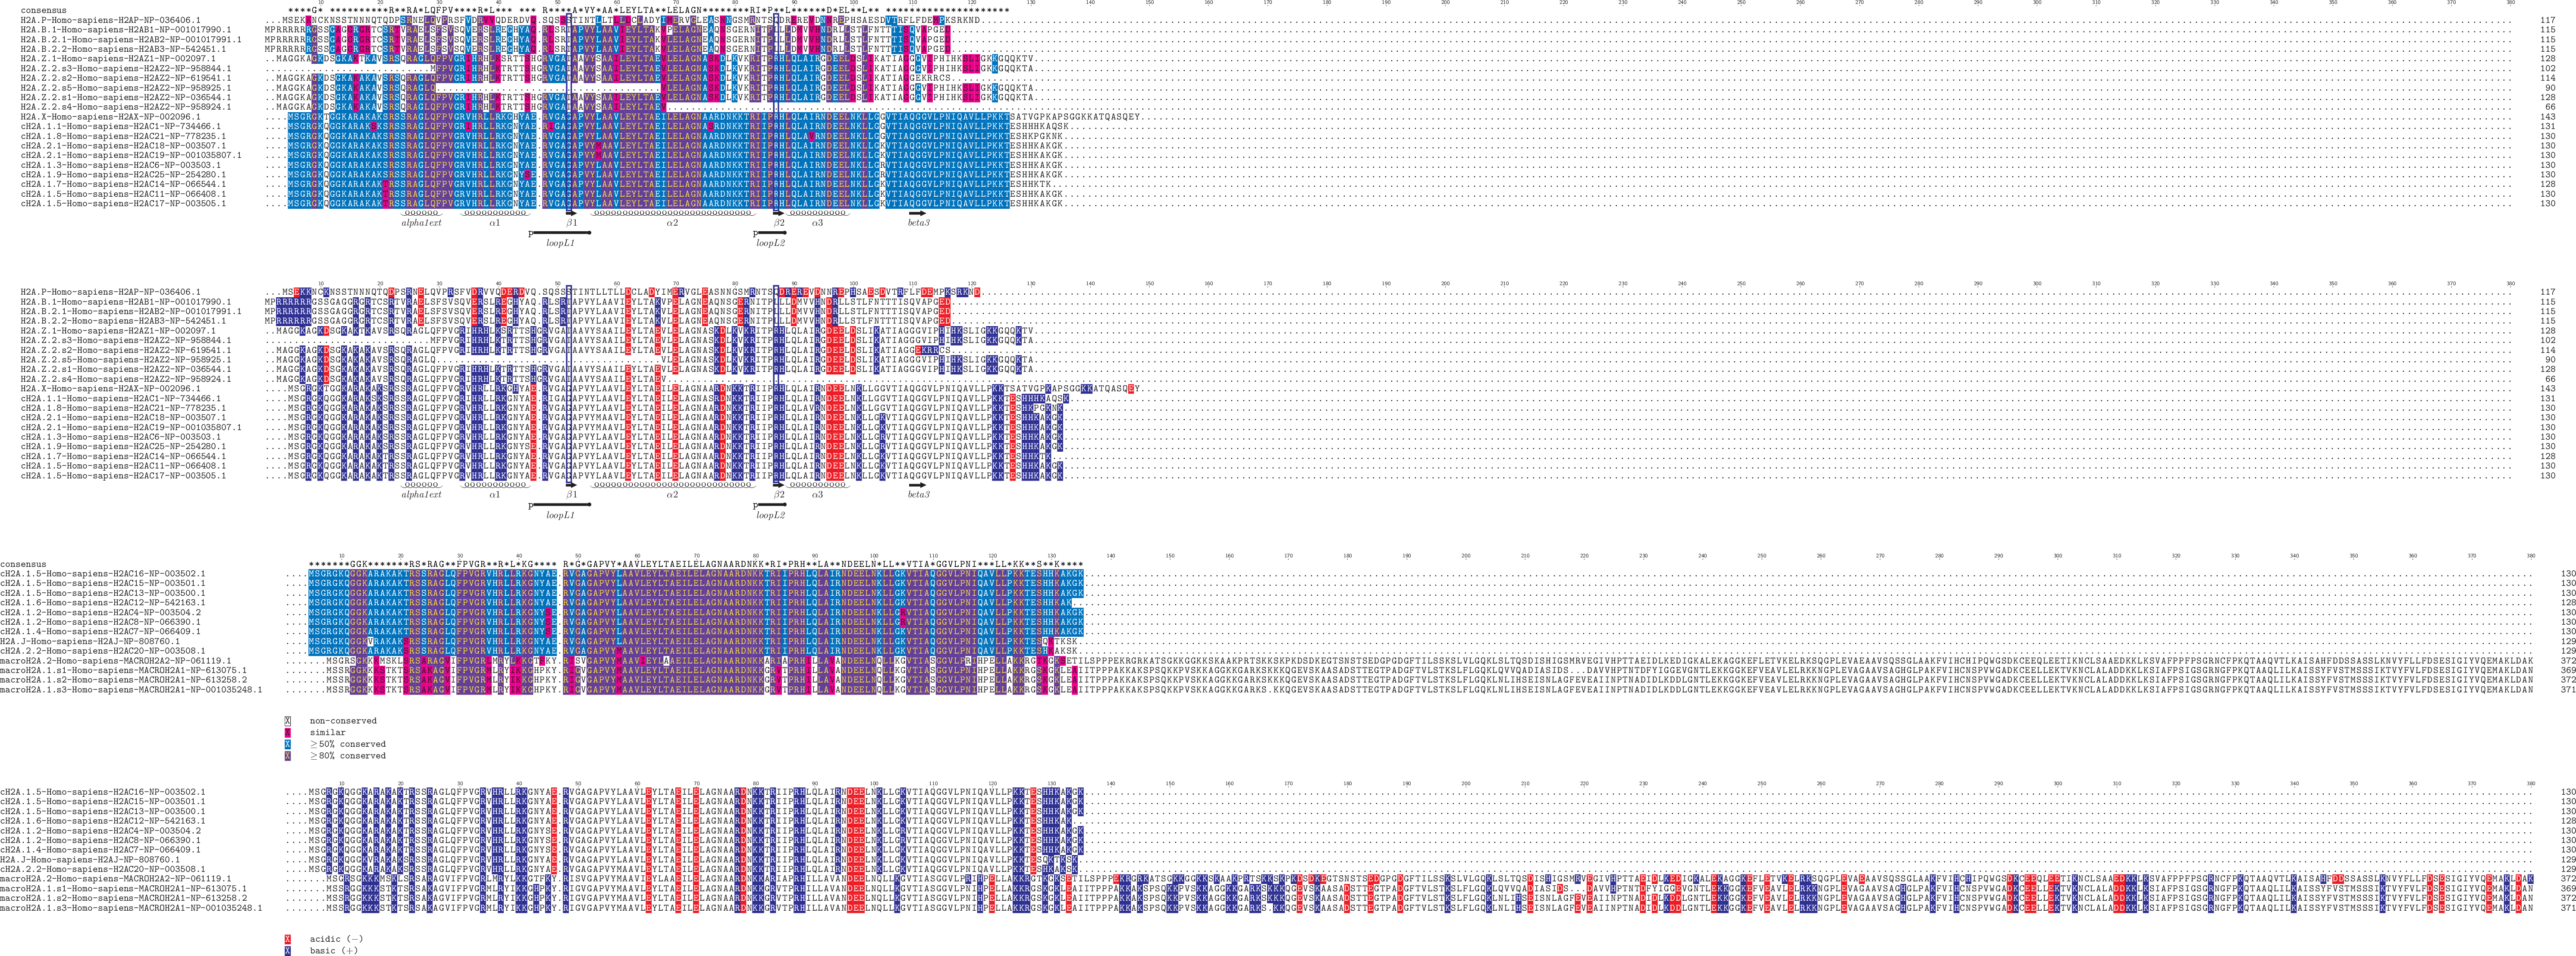

In [89]:
msa=cs.muscle_aln(cs.data.query('type == "H2A" & organism=="Homo sapiens"', engine='python').sort_values(['variant'])['accession'],options=["-maxiters","16","-gapopen","-20"],debug=False)
ipyshade.shadedmsa(msa,shading_modes=['similar','charge_functional'],ruler=True,features=hist_shf4seq(SummaryInfo(msa).dumb_consensus(threshold=0.1,ambiguous='X')))

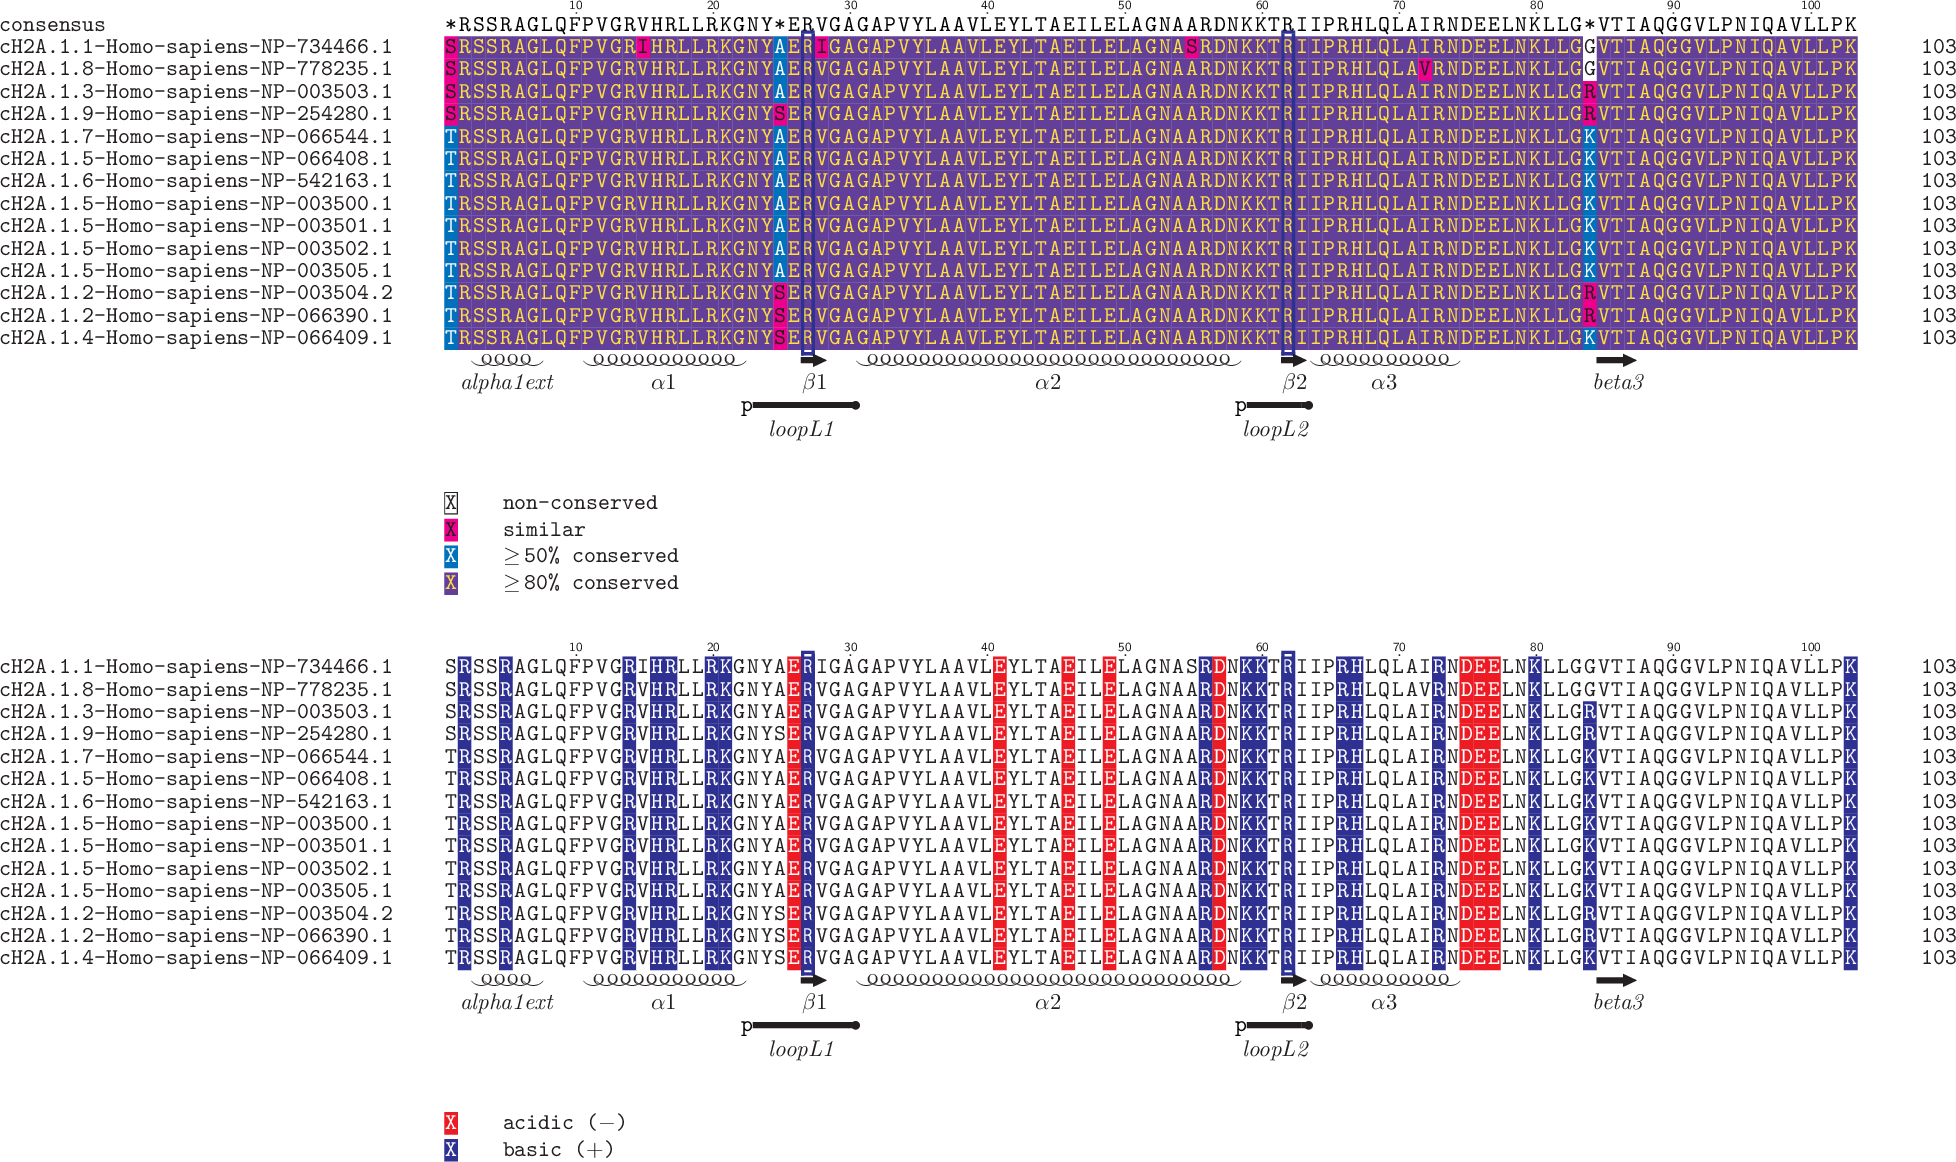

In [210]:
#trim alignment to histone core
core=hist_features(SummaryInfo(msa).dumb_consensus(threshold=0.1,ambiguous='X'))[1]
msa_core=msa[:,core.location.start:core.location.end]
ipyshade.shadedmsa(msa_core,shading_modes=['similar','charge_functional'],ruler=True,features=hist_shf4seq(SummaryInfo(msa_core).dumb_consensus(threshold=0.1,ambiguous='X')))

## Phylogenetic trees using FastTree
#intro to phylogenetics https://www.ebi.ac.uk/training/online/courses/introduction-to-phylogenetics/what-is-a-phylogeny/aspects-of-phylogenies/branches/



In [90]:
msa=cs.muscle_aln(cs.data.query('type == "H2A"  & organism=="Homo sapiens"', engine='python')['accession'],debug=False)

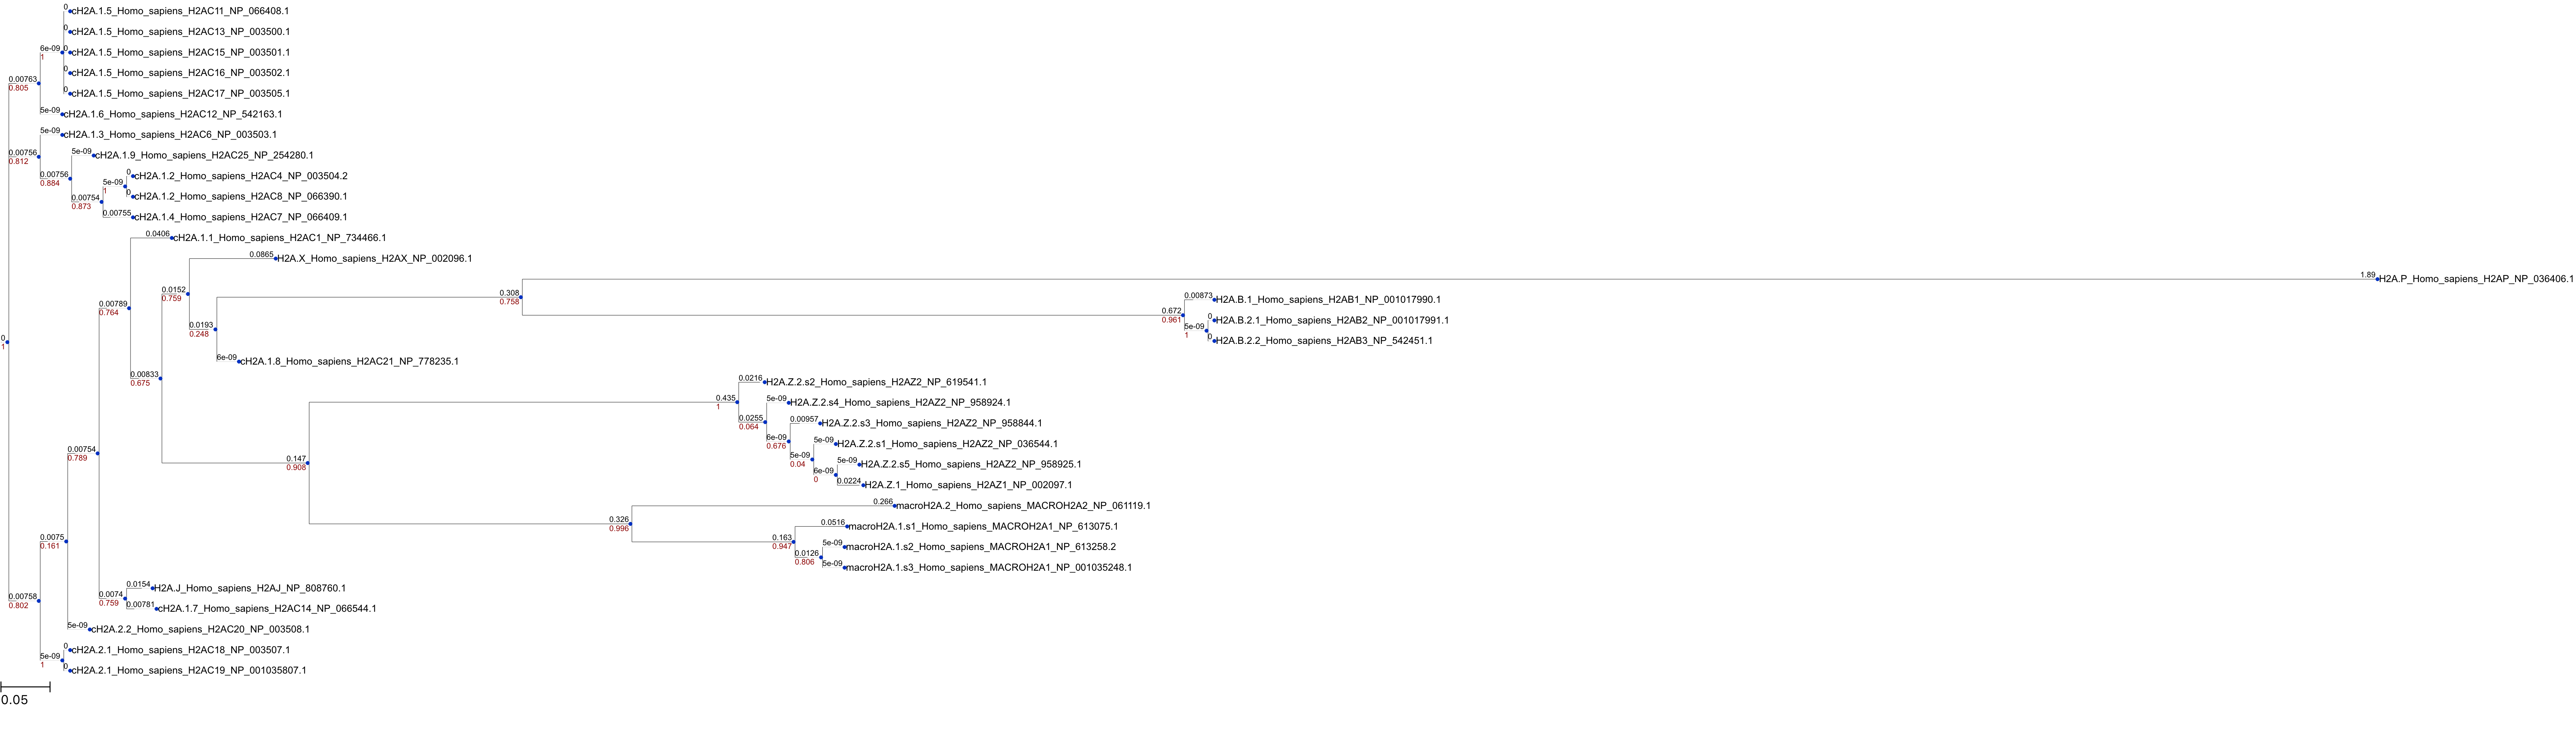

In [91]:
#info about drawing trees http://etetoolkit.org/docs/latest/tutorial/tutorial_drawing.html
!printf "{msa.format('fasta')}" | FastTree > tmp/tree_file 2> /dev/null
t = Tree("tmp/tree_file")
ts = TreeStyle()
# style.mode = "c" # draw tree in circular mode
ts.scale = 1000
ts.show_leaf_name = True
ts.show_branch_length = True
ts.show_branch_support = True
t.render("%%inline", w=2000, units="mm", tree_style=ts)

## Loading and manupilating classification.json
Using it to select subvariants

In [215]:
with open('classification.json') as json_file:
    data = json.load(json_file)

In [216]:
hist_tree=Tree()
dict2tree(hist_tree,data['tree'])
print(hist_tree.get_ascii(show_internal=True))


      /-H2A.Z
     |
   /H2A-H2A.B
  |  |
  |   \-macroH2A
  |
  |--H2B
  |
  |                /-cH3.1_(Metazoa?)
  |   /cH3_(Metazoa)
  |  |             \-cH3.2_(Metazoa?)
  |  |
  |  |--cH3_(Plants)
  |  |
  |  |--cenH3_(Eukarya)
  |  |
  |  |--H3.3_(Eukarya)
  |  |
  |  |--H3.5_(Mammals?)
--|  |
  |-H3--H3.5_(Hominids?)
  |  |
  |  |--H3.Y_(Primates?)
  |  |
  |  |--H3.P_(Moneuplotes?)
  |  |
  |  |--H3.V_(Trypanosomes?)
  |  |
  |  |--H3.B_(Giardia?)
  |  |
  |  |--H3_(Viruses)
  |  |
  |   \-H3_unclassified
  |
  |--H4
  |
   \-Archaeal


In [217]:
#Selection all sequences for an internal node variant
ss='variant.str.contains("Nonsense")'
for node in hist_tree.search_nodes(name='H2A.Z')[0].traverse():
    ss=ss+f' | variant.str.contains("{node.name}")'
print(ss)

cs.data.query(f'{ss} & `class`=="Mammalia"', engine='python')



variant.str.contains("Nonsense") | variant.str.contains("H2A.Z")


accession type variant_group                    variant  \
NP_002097.1  NP_002097.1  H2A         H2A.Z     H2A.Z.1_(Homo_sapiens)   
NP_036544.1  NP_036544.1  H2A         H2A.Z  H2A.Z.2.s1_(Homo_sapiens)   
NP_619541.1  NP_619541.1  H2A         H2A.Z  H2A.Z.2.s2_(Homo_sapiens)   
NP_958844.1  NP_958844.1  H2A         H2A.Z  H2A.Z.2.s3_(Homo_sapiens)   
NP_958924.1  NP_958924.1  H2A         H2A.Z  H2A.Z.2.s4_(Homo_sapiens)   
NP_958925.1  NP_958925.1  H2A         H2A.Z  H2A.Z.2.s5_(Homo_sapiens)   

            doublet   gi ncbi_gene_id hgnc_gene_name taxonomy_id  \
NP_002097.1     NaN  NaN         3015          H2AZ1        9606   
NP_036544.1     NaN  NaN        94239          H2AZ2        9606   
NP_619541.1     NaN  NaN        94239          H2AZ2        9606   
NP_958844.1     NaN  NaN        94239          H2AZ2        9606   
NP_958924.1     NaN  NaN        94239          H2AZ2        9606   
NP_958925.1     NaN  NaN        94239          H2AZ2        9606   

                 organism    phylum     class taxonomy_group info references  \
NP_002097.1  Homo sapiens  Chordata  Mammalia       Mammalia        25731851   
NP_036544.1  Homo sapiens  Chordata  Mammalia       Mammalia        22467210   
NP_619541.1  Homo sapiens  Chordata  Mammalia       Mammalia        22467210   
NP_958844.1  Homo sapiens  Chordata  Mammalia       Mammalia        22467210   
NP_958924.1  Homo sapiens  Chordata  Mammalia       Mammalia        22467210   
NP_958925.1  Homo sapiens  Chordata  Mammalia       Mammalia        22467210   

                                                      sequence  
NP_002097.1  MAGGKAGKDSGKAKTKAVSRSQRAGLQFPVGRIHRHLKSRTTSHGR...  
NP_036544.1  MAGGKAGKDSGKAKAKAVSRSQRAGLQFPVGRIHRHLKTRTTSHGR...  
NP_619541.1  MAGGKAGKDSGKAKAKAVSRSQRAGLQFPVGRIHRHLKTRTTSHGR...  
NP_958844.1  MFPVGRIHRHLKTRTTSHGRVGATAAVYSAAILEYLTAEVLELAGN...  
NP_958924.1  MAGGKAGKDSGKAKAKAVSRSQRAGLQFPVGRIHRHLKTRTTSHGR...  
NP_958925.1  MAGGKAGKDSGKAKAKAVSRSQRAGLQVLELAGNASKDLKVKRITP...

## Preparation of seed alignments
Workflow:

0. Generate draft_seeds automatically with Muscle
We should do a progressive alignment from subvariants to types. Profile-to-profile alignment. Postorder (left,right,root) tree traversal is just what we need for that!

Loop through all types, variants, subvariants
1. Copy manually to seeds, View MSA with features, check phylogeny, edit by hand if needed, e.g. in AliView (copy paste from file)
2. Realign profile-to-profile - check.

In [49]:
!mkdir -p draft_seeds

In [50]:
draft_seeds_msa={}

In [51]:
#generate draft seeds - needs debugging
for node in hist_tree.traverse("postorder"):
    print("Processing ",node.name)
    if(node.is_leaf()): # we get sequences for that variant and align them.
        draft_seeds_msa[node.name]=cs.muscle_aln(cs.data.query(f'type=="{node.name}" | variant.str.contains("{node.name}")', engine='python')['accession'],debug=False)
        print(node.name,"Alignment length:",len(draft_seeds_msa[node.name]))
        with open(f'draft_seeds/{node.name}.fasta','w') as f:
            f.write(draft_seeds_msa[node.name].format('fasta'))
    elif not node.is_root(): # we will do profile to profile alignment
        #we should first check if there are seqs with this subrariant as the most specific one
        print(f"\t Node is internal, progressive alignment:")
        msa=cs.muscle_aln(cs.data.query(f'variant.str.contains(r"(^|\\s){node.name}($|\\s)")')['accession'],debug=False)
        draft_seeds_msa[node.name+'_only']=msa
        print(f"\t\t For {node.name} aligned {len(msa)} sequences")
        ch=node.get_children() #get children
#         msa=draft_seeds_msa[ch[0].name]
        #progressively align
        for i in range(len(ch)):
            if(len(msa)==0):
                msa=draft_seeds_msa[ch[i].name]
                print(f"\t\t Adding child {node.name} aligned {len(draft_seeds_msa[ch[i].name])} sequences")
                continue
            elif(len(draft_seeds_msa[ch[i].name])!=0):
                msa=muscle_p2p_aln(msa,draft_seeds_msa[ch[i].name])
                print(f"\t\t Adding child {node.name} aligned {len(draft_seeds_msa[ch[i].name])} sequences")
            else:
                continue
        draft_seeds_msa[node.name]=msa
        print(node.name,"Alignment length:",len(draft_seeds_msa[node.name]))
        with open(f'draft_seeds/{node.name}.fasta','w') as f:
            f.write(draft_seeds_msa[node.name].format('fasta'))
        with open(f'draft_seeds/{node.name}_only.fasta','w') as f:
            f.write(draft_seeds_msa[node.name+'_only'].format('fasta'))
#         print(f"\t\t Final for {node.name} aligned {len(draft_seeds_msa[node.name])} sequences")
    else:
        continue


Processing  H2A.Z
H2A.Z Alignment length: 29
Processing  H2A.B
H2A.B Alignment length: 16
Processing  macroH2A
macroH2A Alignment length: 12
Processing  H2A
	 Node is internal, progressive alignment:
		 For H2A aligned 0 sequences
		 Adding child H2A aligned 29 sequences
		 Adding child H2A aligned 16 sequences
		 Adding child H2A aligned 12 sequences
H2A Alignment length: 57
Processing  H2B
H2B Alignment length: 75
Processing  cH3.1_(Metazoa?)
cH3.1_(Metazoa?) Alignment length: 0
Processing  cH3.2_(Metazoa?)
cH3.2_(Metazoa?) Alignment length: 0
Processing  cH3_(Metazoa)
	 Node is internal, progressive alignment:
		 For cH3_(Metazoa) aligned 0 sequences
		 Adding child cH3_(Metazoa) aligned 0 sequences
		 Adding child cH3_(Metazoa) aligned 0 sequences
cH3_(Metazoa) Alignment length: 0
Processing  cH3_(Plants)
cH3_(Plants) Alignment length: 0
Processing  cenH3_(Eukarya)
cenH3_(Eukarya) Alignment length: 0
Processing  H3.3_(Eukarya)
H3.3_(Eukarya) Alignment length: 0
Processing  H3.5_(Ma

In [54]:
#Copy draft_seeds to seeds manually, analyze, adjust, save, realign
!mkdir -p seeds
#Here is the list and order of alignment we need to check
for node in hist_tree.traverse("postorder"):
    if(not node.is_leaf() and not node.is_root()):
        print(node.name+'_only')
    print(node.name)
    

H2A.Z
H2A.B
macroH2A
H2A_only
H2A
H2B
cH3.1_(Metazoa?)
cH3.2_(Metazoa?)
cH3_(Metazoa)_only
cH3_(Metazoa)
cH3_(Plants)
cenH3_(Eukarya)
H3.3_(Eukarya)
H3.5_(Mammals?)
H3.5_(Hominids?)
H3.Y_(Primates?)
H3.P_(Moneuplotes?)
H3.V_(Trypanosomes?)
H3.B_(Giardia?)
H3_(Viruses)
H3_unclassified
H3_only
H3
H4
Archaeal



In [34]:
name='H2A'
!echo $name\.fasta

H2A.fasta


In [44]:
#RELoad curated seeds
import os.path
curated_seeds_msa={}
for node in hist_tree.traverse("postorder"):
    if os.path.isfile(f"seeds/{node.name}.fasta"):
        print("Loading ",node.name)
        curated_seeds_msa[node.name] =   AlignIO.read(f"seeds/{node.name}.fasta", "fasta") if os.path.getsize(f"seeds/{node.name}.fasta") >0 else []
    if os.path.isfile(f"seeds/{node.name}_only.fasta"):
        print("Loading ",node.name+"_only")
        curated_seeds_msa[node.name+"_only"] =  AlignIO.read(f"seeds/{node.name}_only.fasta", "fasta") if os.path.getsize(f"seeds/{node.name}_only.fasta") >0  else []

Loading  H2A.Z
Loading  H2A.B
Loading  macroH2A
Loading  H2A_only


In [45]:
#if terminal leaf or only - copy
if('_only' in name):
    !cp draft_seeds/$name\.fasta seeds/$name\.fasta
else:
    if(hist_tree.search_nodes(name=name)[0].is_leaf()):
        !cp draft_seeds/$name\.fasta seeds/$name\.fasta

    


In [46]:
#if internal node - assemble
if(not (hist_tree.search_nodes(name=name)[0].is_leaf() or ('_only' in name))):
    print("Need to assemble following")
    print("name"+'_only')
    for node in hist_tree.search_nodes(name='H2A')[0].traverse("postorder"):
        print(node.name)

Need to assemble following
name_only
H2A.Z
H2A.B
macroH2A
H2A


In [47]:
#Realign from edited seeds for an internal node. TODO visit name_only and children.
#generate draft seeds - needs debugging
ch=hist_tree.search_nodes(name=name)[0].get_children()
chnames=[n.name for n in ch]
msa=curated_seeds_msa[f'{name}_only']
for n in chnames:
    if(len(msa)==0):
        msa=curated_seeds_msa[n]
        print(f"\t\t Adding child {n} aligned {len(curated_seeds_msa[n])} sequences")
        continue
    elif(len(curated_seeds_msa[n])!=0):
        msa=muscle_p2p_aln(msa,curated_seeds_msa[n])
        print(f"\t\t Adding child {n} aligned {len(curated_seeds_msa[n])} sequences")
    else:
        continue
    curated_seeds_msa[name]=msa
    print(node.name,"Alignment length:",len(curated_seeds_msa[name]))
    with open(f'seeds/{name}.fasta','w') as f:
        f.write(curated_seeds_msa[name].format('fasta'))



		 Adding child H2A.Z aligned 29 sequences
		 Adding child H2A.B aligned 16 sequences
H2A Alignment length: 45
		 Adding child macroH2A aligned 12 sequences
H2A Alignment length: 57


In [48]:

msa = AlignIO.read(f"seeds/{name}.fasta", "fasta")
ipyshade.shadedmsa(msa,shading_modes=['similar','charge_functional'],ruler=True,features=hist_shf4seq(SummaryInfo(msa).dumb_consensus(threshold=0.1,ambiguous='X')))

mv: rename /var/folders/sy/v9x090kx0ml2spy89cjq4q280000gn/T/tmpk4rzto8c/align.pdf to /var/folders/sy/v9x090kx0ml2spy89cjq4q280000gn/T/tmpvlv1ean7/tempshade.pdf: No such file or directory
!!! Error: Input file `/var/folders/sy/v9x090kx0ml2spy89cjq4q280000gn/T/tmpvlv1ean7/tempshade.pdf' not found!


 Please consider installing 'sudo apt-get install texlive-extra-utils' 



convert: unable to open image '/var/folders/sy/v9x090kx0ml2spy89cjq4q280000gn/T/tmpvlv1ean7/tempshade.pdf': No such file or directory @ error/blob.c/OpenBlob/3527.
convert: no images defined `/var/folders/sy/v9x090kx0ml2spy89cjq4q280000gn/T/tmp8lmk85y9.png' @ error/convert.c/ConvertImageCommand/3327.


FileNotFoundError: [Errno 2] No such file or directory: '/var/folders/sy/v9x090kx0ml2spy89cjq4q280000gn/T/tmpvlv1ean7/tempshade.pdf'

In [52]:
#FastTree

In [53]:
!FastTree < seeds/{name}.fasta > tmp/tree_file 2> /dev/null
t = Tree("tmp/tree_file")
ts = TreeStyle()
# style.mode = "c" # draw tree in circular mode
ts.scale = 1000
ts.show_leaf_name = True
ts.show_branch_length = True
ts.show_branch_support = True
t.render("%%inline", w=2000, units="mm", tree_style=ts)

## Generate feature gff files for seeds

In [20]:
#Load curated seeds by traversing the tree
import os.path
curated_seeds_msa_form_files={}
for node in hist_tree.traverse("postorder"):
    if os.path.isfile(f"seeds/{node.name}.fasta"):
        print("Loading ",node.name)
        curated_seeds_msa_form_files[node.name] =   AlignIO.read(f"seeds/{node.name}.fasta", "fasta") if os.path.getsize(f"seeds/{node.name}.fasta") >0 else []

Loading  H2A.Z
Loading  H2A.B
Loading  macroH2A
Loading  H2A


In [30]:
for k,v in curated_seeds_msa_form_files.items():
    cons=SummaryInfo(v).dumb_consensus(threshold=0.1,ambiguous='X')
    f=hist_features(cons)
    r=SeqRecord(seq=cons,id="Consensus",name="Consensus",features=f)
    with open(f'seeds/{k}.gff3', 'w') as j:
        GFFwrite([r],j,filterids=['inner_core'])

### generate core seeds from seeds

In [11]:
#Make Analyze core seeds
!mkdir -p seeds_core

#### Automatic

In [31]:
import os.path
curated_seeds_msa_form_files={}
for node in hist_tree.traverse("postorder"):
    if os.path.isfile(f"seeds/{node.name}.fasta"):
        print("Loading ",node.name)
        curated_seeds_msa_form_files[node.name] =   AlignIO.read(f"seeds/{node.name}.fasta", "fasta") if os.path.getsize(f"seeds/{node.name}.fasta") >0 else []

Loading  H2A.Z
Loading  H2A.B
Loading  macroH2A
Loading  H2A


In [33]:
for k,msa in curated_seeds_msa_form_files.items():
    core=hist_features(SummaryInfo(msa).dumb_consensus(threshold=0.1,ambiguous='X'))[1]
    msa_core=msa[:,core.location.start:core.location.end]
    with open(f'seeds_core/{k}.fasta','w') as f:
        f.write(msa_core.format('fasta'))

In [12]:
msa = AlignIO.read(f"seeds/{name}.fasta", "fasta")
f=hist_features(SummaryInfo(msa).dumb_consensus(threshold=0.1,ambiguous='X'))
ftsh=hist_shf4seq(SummaryInfo(msa).dumb_consensus(threshold=0.1,ambiguous='X'))

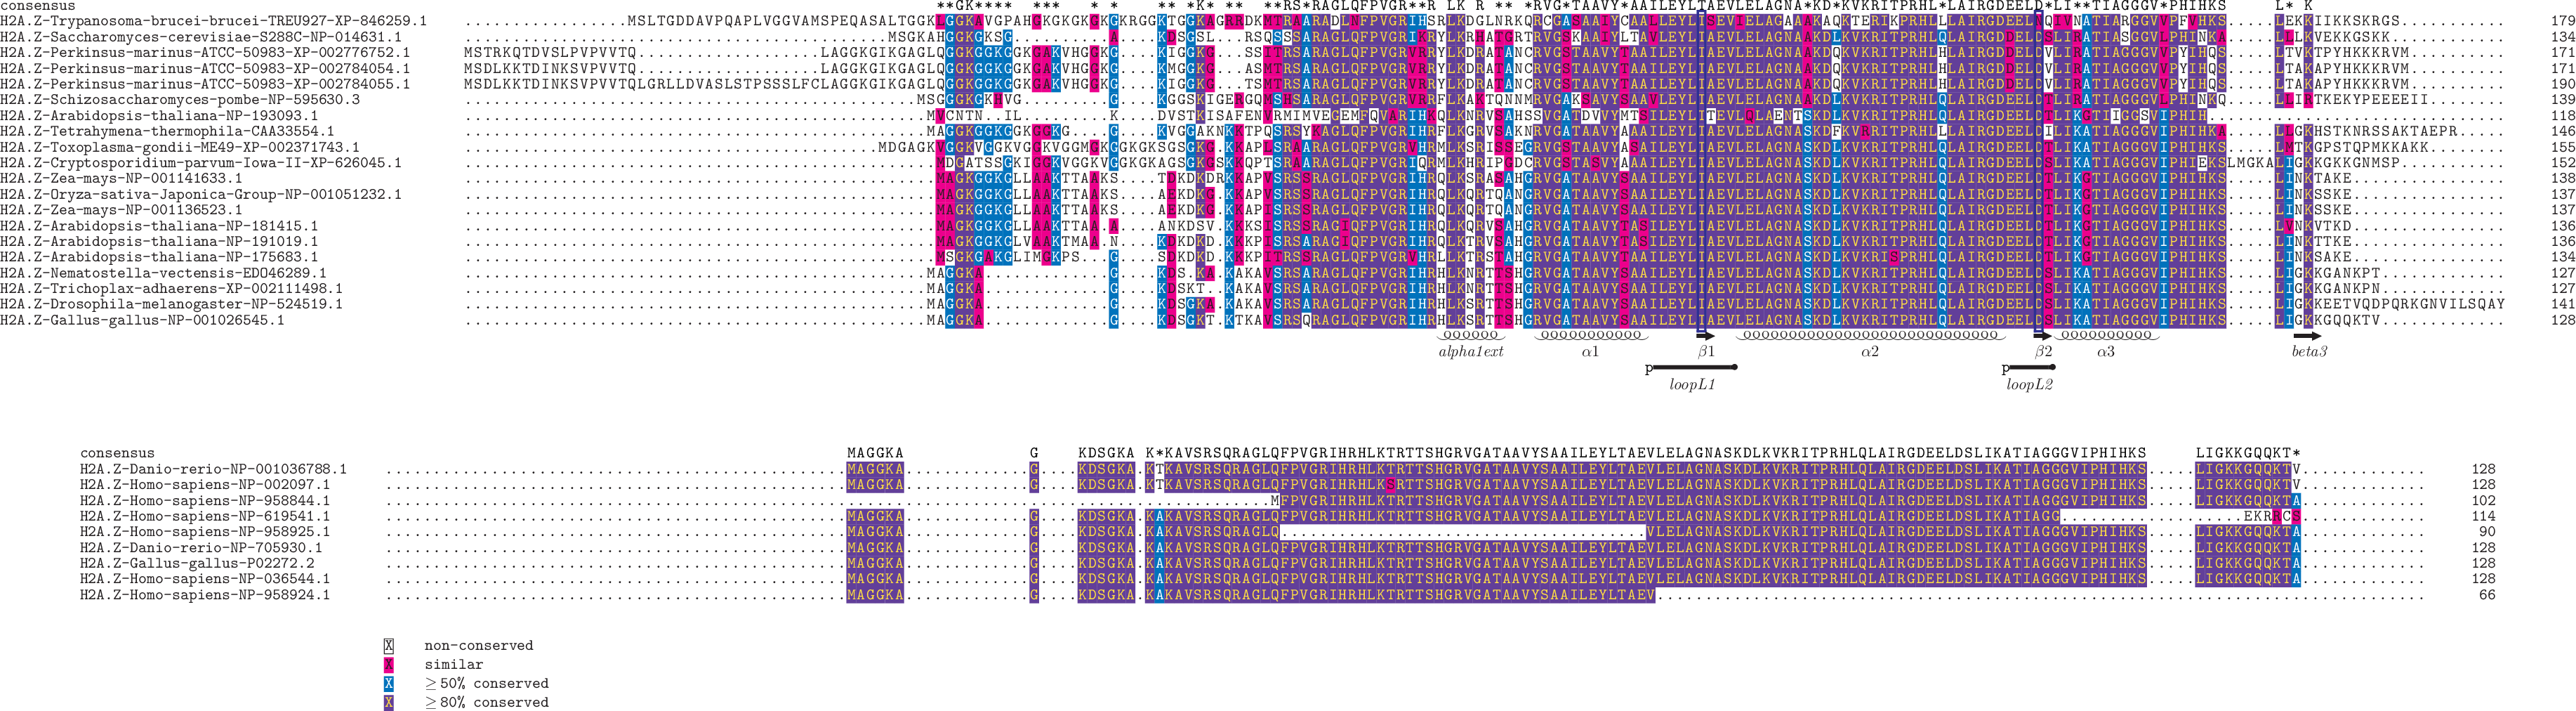

In [13]:
ipyshade.shadedmsa(msa,features=ftsh)

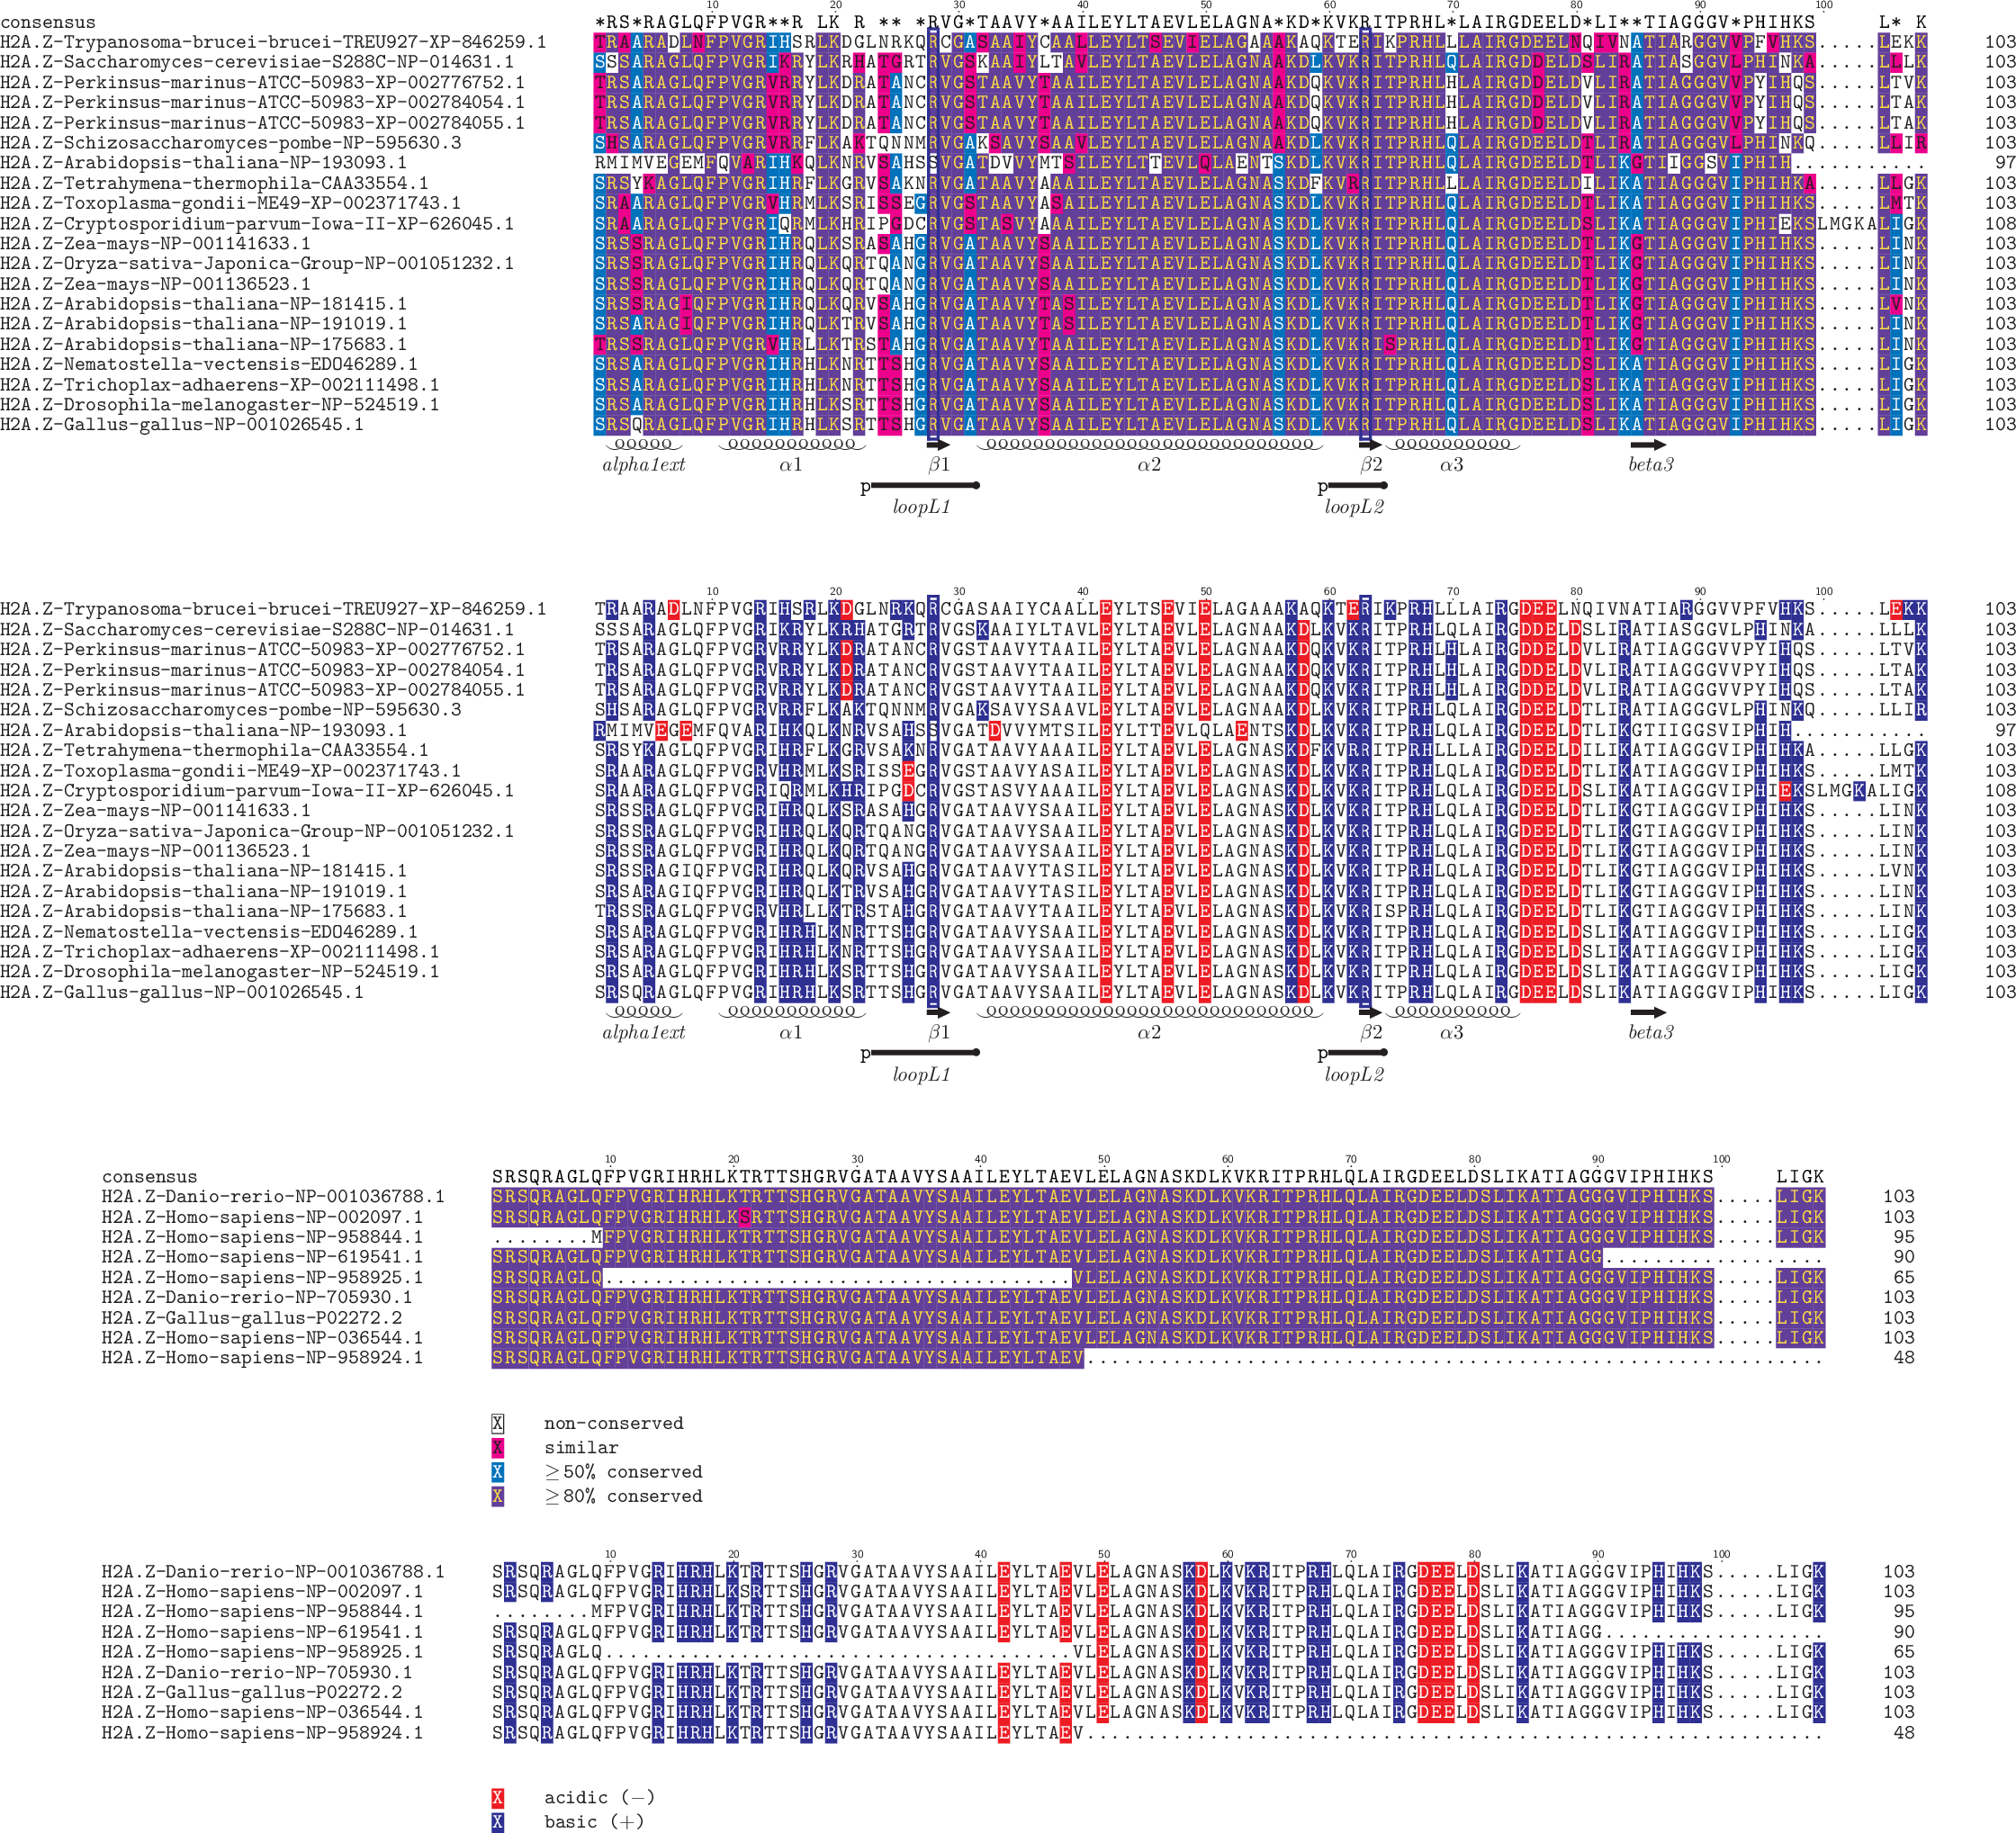

In [16]:
core=hist_features(SummaryInfo(msa).dumb_consensus(threshold=0.1,ambiguous='X'))[1]
msa_core=msa[:,core.location.start:core.location.end]
ipyshade.shadedmsa(msa_core,shading_modes=['similar','charge_functional'],ruler=True,features=hist_shf4seq(SummaryInfo(msa_core).dumb_consensus(threshold=0.1,ambiguous='X')))

In [17]:
with open(f'seeds_core/{name}.fasta','w') as f:
    f.write(msa_core.format('fasta'))

## Generate Tree from Core MSAs

In [50]:
#We will also name the root node Consensus - for the MSA tree viewer to render correctly.
import os.path
for node in hist_tree.traverse("postorder"):
    if os.path.isfile(f"seeds/{node.name}.fasta"):
        print("Building ",node.name)
        name=node.name
        !FastTree -nosupport < seeds_core/{name}.fasta > tmp/tree 2> /dev/null
        !sed '$ s/.$/Consensus;/' tmp/tree > seeds/{name}.tree

Building  H2A.Z
Building  H2A.B
Building  macroH2A
Building  H2A


# Create html pages for browsing curated aligments

In [18]:
!mkdir -p html

## tree with phylocanvas.gl
- current problems - cannot draw internal nodes as glyphs
- cannot make nodes clickable

In [100]:
p="""
<html>
<h1> Classification tree of histones and their variants used in HistoneDB</h1>
<h3>Click on node to view sequence alignment</h3>
<div id="demo">
</div>
<script src="https://unpkg.com/@phylocanvas/phylocanvas.gl@latest/dist/bundle.min.js"></script>
<script>
  const tree = new phylocanvas.PhylocanvasGL(
  document.querySelector("#demo"),
    {
    styles: {
      // set colour, default shape and label
      H3: { fillColour: "blue" },
      H4: { fillColour: "green" },
      H2A: { fillColour: "yellow" },
      H2B: { fillColour: "red" },
      },
    interactive: true,
        showLabels: true,
        showLeafLabels: true,
        showInternalLabels: true,
        //collapsedIds: ["H2A"],
      size: { width: 600, height: 400 },
      source: `%s`,
      type: phylocanvas.TreeTypes.Rectangular,
    },
  );
   //tree.collapseNode("1");
</script>
</html>
"""%hist_tree.write(format=1)
with open('html/tree_phylogl.html','w') as t:
    t.write(p)

### tree with phylocanvas
- current problems - cannot  even label internal nodes
- cannot make nodes clickable


In [101]:
p="""
<!DOCTYPE html>
<html>
<head>
  <style>
    body {
      margin: 0.625em auto;
      max-width: 60em;
    }
    #phylocanvas {
      width: 100%%;
      height: 30em;
    }
  </style>
</head>
<body>
  <h1>Phylocanvas Quickstart</h1>
  <div id="phylocanvas"></div>
  <script type="application/javascript" src="http://cdn.rawgit.com/phylocanvas/phylocanvas-quickstart/v2.8.1/phylocanvas-quickstart.js"></script>
  <script type="application/javascript">
    (function (Phylocanvas) {
      var tree = Phylocanvas.createTree('phylocanvas');
      tree.load('%s');
      tree.setTreeType('rectangular');
      tree.displayLabels();
      tree.displayInternalLabels();
      tree.branches['pcn3'].collapsed = true;
    })(window.Phylocanvas);
  </script>
</body>
</html>
"""%hist_tree.write(format=1)
with open('html/tree_phylo.html','w') as t:
    t.write(p)

### So currently we will stick with pure JS solution using D3
see html/tree_d3.html